In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ Libraries loaded")

✓ Libraries loaded


In [31]:
df = pd.read_csv('data_files_stationary/Hospital ER_Data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (9216, 12)

Column names:
['Patient Id', 'Patient Admission Date', 'Patient First Inital', 'Patient Last Name', 'Patient Gender', 'Patient Age', 'Patient Race', 'Department Referral', 'Patient Admission Flag', 'Patient Satisfaction Score', 'Patient Waittime', 'Patients CM']

Data types:
Patient Id                     object
Patient Admission Date         object
Patient First Inital           object
Patient Last Name              object
Patient Gender                 object
Patient Age                     int64
Patient Race                   object
Department Referral            object
Patient Admission Flag           bool
Patient Satisfaction Score    float64
Patient Waittime                int64
Patients CM                     int64
dtype: object

First few rows:


,Patient Id,Patient Admission Date,Patient First Inital,Patient Last Name,Patient Gender,Patient Age,Patient Race,Department Referral,Patient Admission Flag,Patient Satisfaction Score,Patient Waittime,Patients CM
0,145-39-5406,20-03-2024 08:47,H,Glasspool,M,69,White,NaN,False,10.0,39,0
1,316-34-3057,15-06-2024 11:29,X,Methuen,M,4,Native American/Alaska Native,NaN,True,NaN,27,0
2,897-46-3852,20-06-2024 09:13,P,Schubuser,F,56,African American,General Practice,True,9.0,55,0
3,358-31-9711,04-02-2024 22:34,U,Titcombe,F,24,Native American/Alaska Native,General Practice,True,8.0,31,0
4,289-26-0537,04-09-2024 17:48,Y,Gionettitti,M,5,African American,Orthopedics,False,NaN,10,0


In [32]:
print("Dataset Info:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic statistics:\n{df.describe()}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9216 entries, 0 to 9215
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient Id                  9216 non-null   object 
 1   Patient Admission Date      9216 non-null   object 
 2   Patient First Inital        9216 non-null   object 
 3   Patient Last Name           9216 non-null   object 
 4   Patient Gender              9216 non-null   object 
 5   Patient Age                 9216 non-null   int64  
 6   Patient Race                9216 non-null   object 
 7   Department Referral         3816 non-null   object 
 8   Patient Admission Flag      9216 non-null   bool   
 9   Patient Satisfaction Score  2517 non-null   float64
 10  Patient Waittime            9216 non-null   int64  
 11  Patients CM                 9216 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 801.1+ KB
None

Mi

In [33]:
# Look at all columns to find date-related ones
print("Sample of each column:")
for col in df.columns:
    print(f"\n{col}:")
    print(df[col].head(3))

Sample of each column:

Patient Id:
0    145-39-5406
1    316-34-3057
2    897-46-3852
Name: Patient Id, dtype: object

Patient Admission Date:
0    20-03-2024 08:47
1    15-06-2024 11:29
2    20-06-2024 09:13
Name: Patient Admission Date, dtype: object

Patient First Inital:
0    H
1    X
2    P
Name: Patient First Inital, dtype: object

Patient Last Name:
0    Glasspool
1      Methuen
2    Schubuser
Name: Patient Last Name, dtype: object

Patient Gender:
0    M
1    M
2    F
Name: Patient Gender, dtype: object

Patient Age:
0    69
1     4
2    56
Name: Patient Age, dtype: int64

Patient Race:
0                            White
1    Native American/Alaska Native
2                 African American
Name: Patient Race, dtype: object

Department Referral:
0                 NaN
1                 NaN
2    General Practice
Name: Department Referral, dtype: object

Patient Admission Flag:
0    False
1     True
2     True
Name: Patient Admission Flag, dtype: bool

Patient Satisfaction Score:


In [34]:
date_column = 'Patient Admission Date' 
df[date_column] = pd.to_datetime(df[date_column])

daily_visits = df.groupby(df[date_column].dt.date).size().reset_index()
daily_visits.columns = ['date', 'visits']
daily_visits['date'] = pd.to_datetime(daily_visits['date'])
daily_visits.set_index('date', inplace=True)
daily_visits = daily_visits.sort_index()

print(f"Date range: {daily_visits.index.min()} to {daily_visits.index.max()}")
print(f"Total days: {len(daily_visits)}")
print(f"Average daily visits: {daily_visits['visits'].mean():.1f}")
daily_visits.head()

Date range: 2023-04-01 00:00:00 to 2024-10-30 00:00:00
Total days: 579
Average daily visits: 15.9


,visits
date,
2023-04-01,19
2023-04-02,13
2023-04-03,14
2023-04-04,9
2023-04-05,19


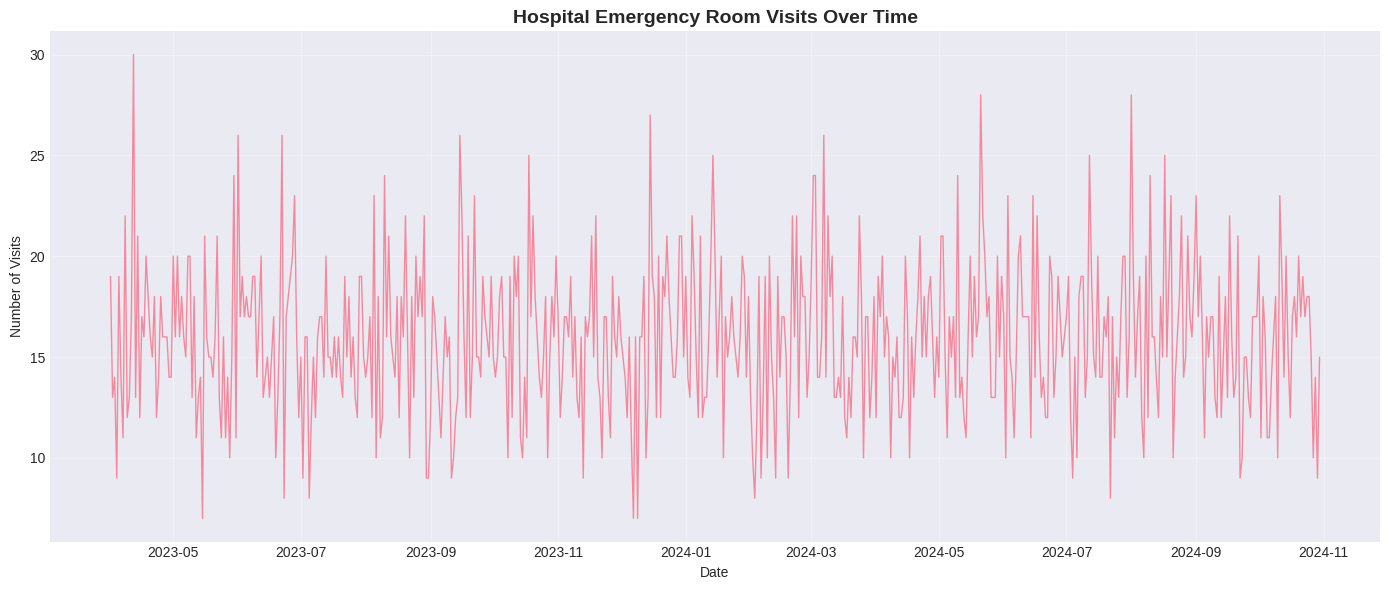

In [35]:
plt.figure(figsize=(14, 6))
plt.plot(daily_visits.index, daily_visits['visits'], linewidth=1, alpha=0.8)
plt.title('Hospital Emergency Room Visits Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

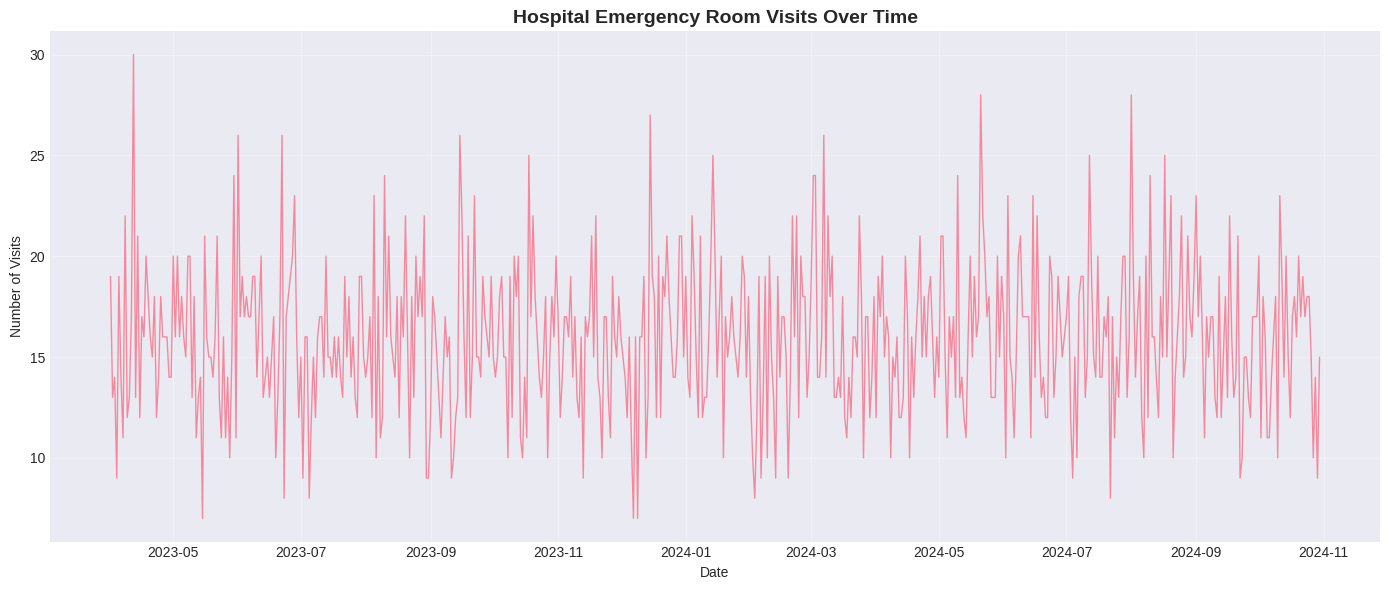

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(daily_visits.index, daily_visits['visits'], linewidth=1, alpha=0.8)
plt.title('Hospital Emergency Room Visits Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


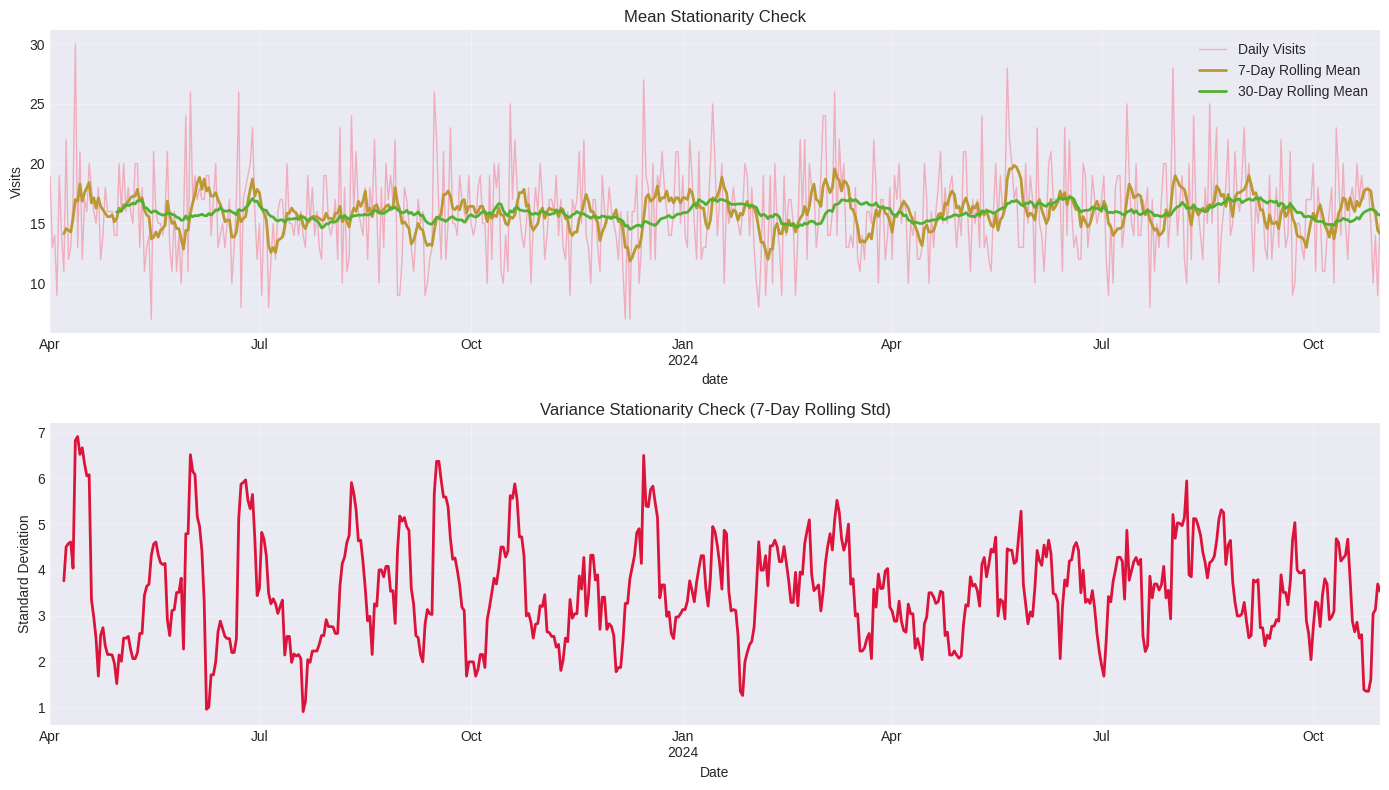

In [37]:
# Calculate 7-day and 30-day rolling statistics
ts = daily_visits['visits']
rolling_mean_7 = ts.rolling(window=7).mean()
rolling_std_7 = ts.rolling(window=7).std()
rolling_mean_30 = ts.rolling(window=30).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Mean over time
ts.plot(ax=ax1, label='Daily Visits', alpha=0.5, linewidth=1)
rolling_mean_7.plot(ax=ax1, label='7-Day Rolling Mean', linewidth=2)
rolling_mean_30.plot(ax=ax1, label='30-Day Rolling Mean', linewidth=2)
ax1.set_title('Mean Stationarity Check')
ax1.legend()
ax1.set_ylabel('Visits')
ax1.grid(True, alpha=0.3)

# Variance over time
rolling_std_7.plot(ax=ax2, linewidth=2, color='crimson')
ax2.set_title('Variance Stationarity Check (7-Day Rolling Std)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Standard Deviation')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=''):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    
    Parameters:
    -----------
    series : pandas Series
        Time series data to test
    name : str
        Name of series for display
        
    Returns:
    --------
    p_value : float
        p-value from the test
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f'{"="*70}')
    print(f'Augmented Dickey-Fuller Test: {name}')
    print(f'{"="*70}')
    print(f'ADF Statistic:        {result[0]:.6f}')
    print(f'p-value:              {result[1]:.6f}')
    print(f'Number of lags used:  {result[2]}')
    print(f'Number of observations: {result[3]}')
    print(f'\nCritical Values:')
    for key, value in result[4].items():
        print(f'  {key:>4}: {value:>8.3f}')
    
    print(f'\n{"Interpretation:":_<70}')
    if result[1] < 0.05:
        print(f'✓ REJECT null hypothesis (p = {result[1]:.4f} < 0.05)')
        print(f'  → Series IS STATIONARY')
    else:
        print(f'✗ FAIL TO REJECT null hypothesis (p = {result[1]:.4f} ≥ 0.05)')
        print(f'  → Series is NON-STATIONARY')
    
    print(f'{"="*70}\n')
    return result[1]

In [39]:
ts = daily_visits['visits']
p_value_original = adf_test(ts, 'Original Daily ER Visits')

Augmented Dickey-Fuller Test: Original Daily ER Visits
ADF Statistic:        -24.094331
p-value:              0.000000
Number of lags used:  0
Number of observations: 578

Critical Values:
    1%:   -3.442
    5%:   -2.867
   10%:   -2.569

Interpretation:_______________________________________________________
✓ REJECT null hypothesis (p = 0.0000 < 0.05)
  → Series IS STATIONARY



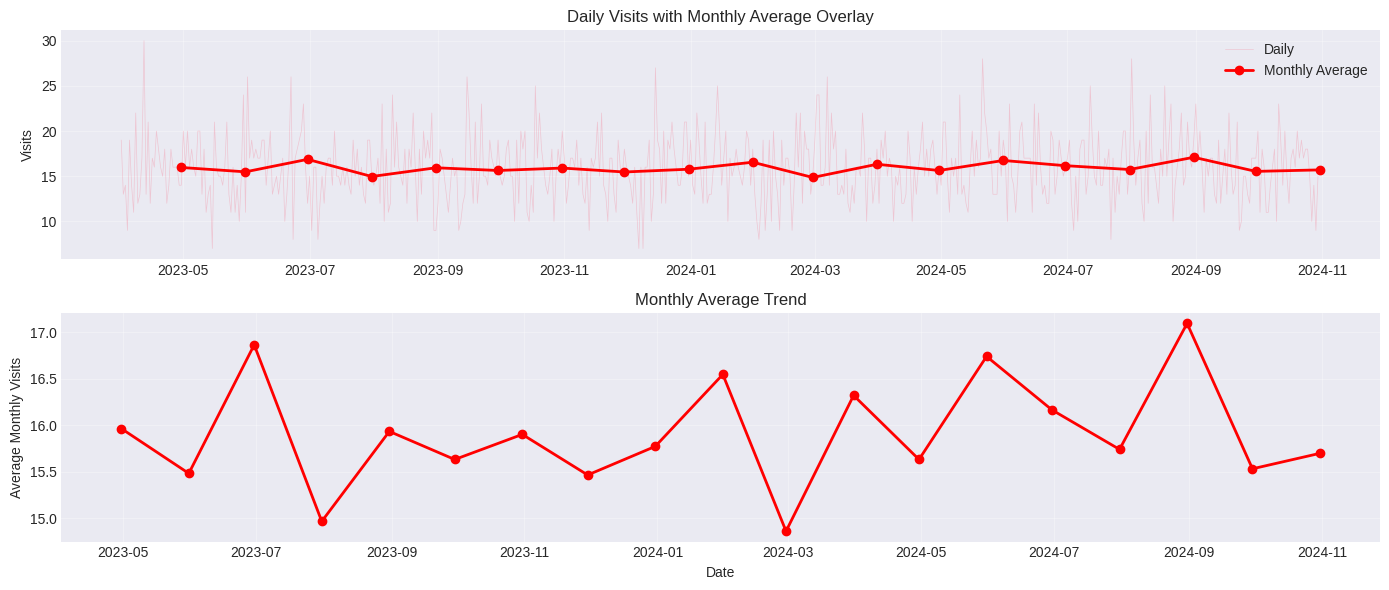

Monthly trend slope: 0.017 visits/month
Trend p-value: 0.5059
→ No significant trend detected


In [40]:
# Check if there's a hidden trend by looking at monthly averages
monthly_avg = ts.resample('M').mean()

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(ts.index, ts.values, alpha=0.3, linewidth=0.5, label='Daily')
plt.plot(monthly_avg.index, monthly_avg.values, linewidth=2, 
         color='red', marker='o', label='Monthly Average')
plt.title('Daily Visits with Monthly Average Overlay')
plt.ylabel('Visits')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(monthly_avg.index, monthly_avg.values, linewidth=2, 
         color='red', marker='o')
plt.title('Monthly Average Trend')
plt.xlabel('Date')
plt.ylabel('Average Monthly Visits')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simple trend test
from scipy import stats
x = np.arange(len(monthly_avg))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, monthly_avg.values)
print(f'Monthly trend slope: {slope:.3f} visits/month')
print(f'Trend p-value: {p_value:.4f}')
if p_value < 0.05:
    print('→ Significant trend detected over time')
else:
    print('→ No significant trend detected')

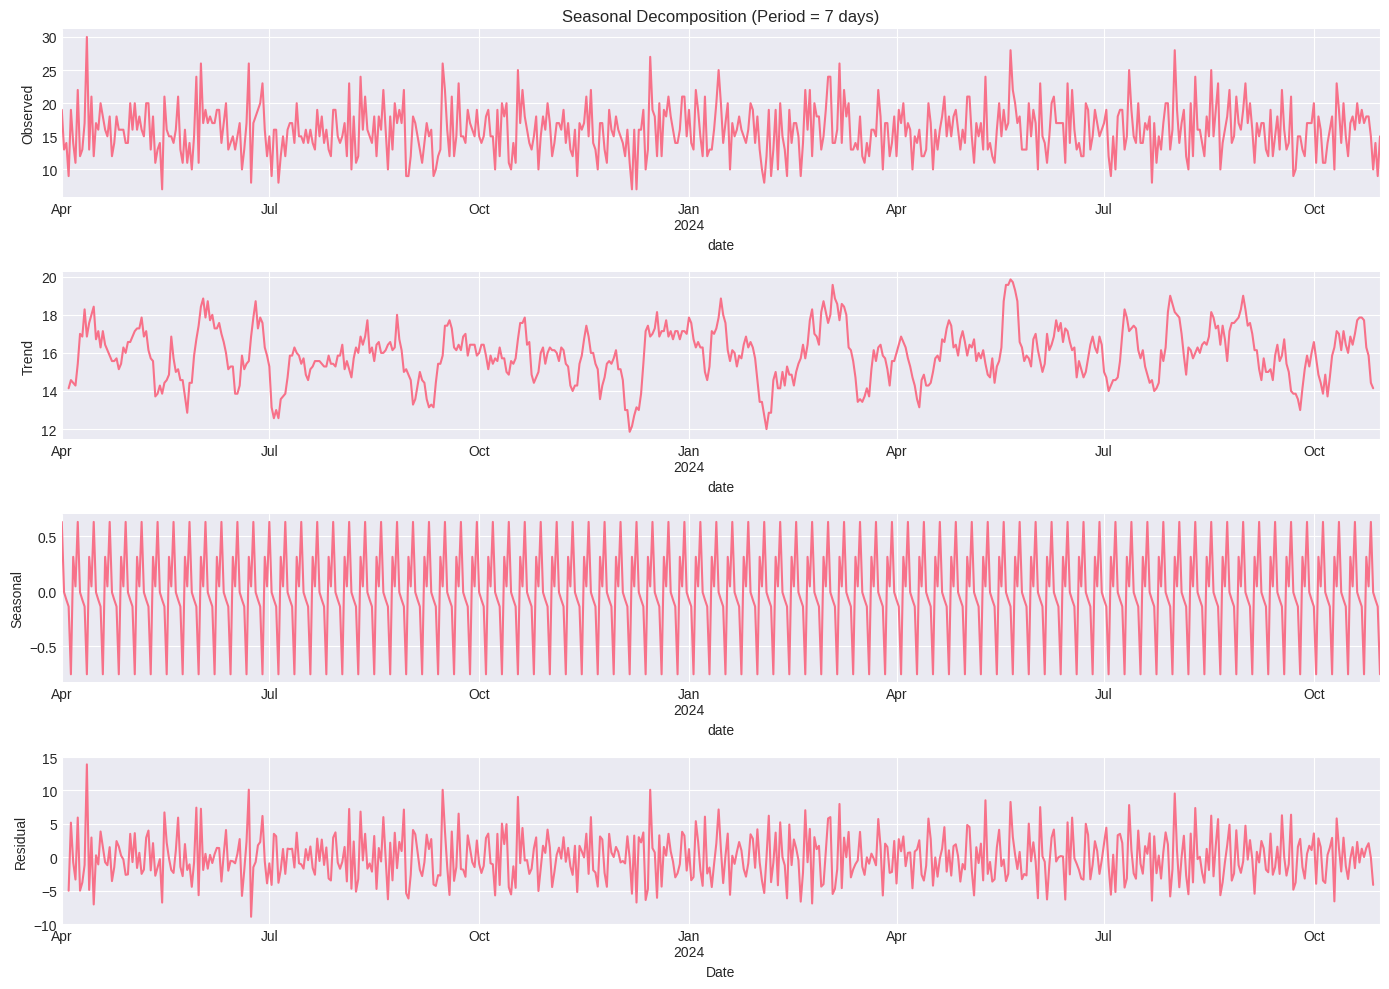

Augmented Dickey-Fuller Test: Trend Component
ADF Statistic:        -5.751300
p-value:              0.000001
Number of lags used:  19
Number of observations: 553

Critical Values:
    1%:   -3.442
    5%:   -2.867
   10%:   -2.570

Interpretation:_______________________________________________________
✓ REJECT null hypothesis (p = 0.0000 < 0.05)
  → Series IS STATIONARY



In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
decomposition = seasonal_decompose(ts, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposition.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_title('Seasonal Decomposition (Period = 7 days)')

decomposition.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Test if trend component is stationary
trend_clean = decomposition.trend.dropna()
if len(trend_clean) > 10:
    adf_test(trend_clean, 'Trend Component')

In [42]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, name=''):
    """
    Perform KPSS test for stationarity
    
    Parameters:
    -----------
    series : pandas Series
        Time series data to test
    name : str
        Name of series for display
        
    Returns:
    --------
    p_value : float
        p-value from the test
    """
    result = kpss(series.dropna(), regression='c', nlags='auto')
    
    print(f'{"="*70}')
    print(f'KPSS Test: {name}')
    print(f'{"="*70}')
    print(f'KPSS Statistic:       {result[0]:.6f}')
    print(f'p-value:              {result[1]:.6f}')
    print(f'Number of lags used:  {result[2]}')
    print(f'\nCritical Values:')
    for key, value in result[3].items():
        print(f'  {key:>4}: {value:>8.3f}')
    
    print(f'\n{"Interpretation:":_<70}')
    if result[1] < 0.05:
        print(f'✗ REJECT null hypothesis (p = {result[1]:.4f} < 0.05)')
        print(f'  → Series is NON-STATIONARY')
    else:
        print(f'✓ FAIL TO REJECT null hypothesis (p = {result[1]:.4f} ≥ 0.05)')
        print(f'  → Series IS STATIONARY')
    
    print(f'{"="*70}\n')
    return result[1]

In [43]:
p_value_kpss = kpss_test(ts, 'Original Daily ER Visits')


KPSS Test: Original Daily ER Visits
KPSS Statistic:       0.092138
p-value:              0.100000
Number of lags used:  2

Critical Values:
   10%:    0.347
    5%:    0.463
  2.5%:    0.574
    1%:    0.739

Interpretation:_______________________________________________________
✓ FAIL TO REJECT null hypothesis (p = 0.1000 ≥ 0.05)
  → Series IS STATIONARY



In [44]:
# Store results
results = {
    'Test': ['ADF', 'KPSS'],
    'Statistic': [None, None],
    'p-value': [p_value_original, p_value_kpss],
    'Conclusion': [
        'Stationary' if p_value_original < 0.05 else 'Non-stationary',
        'Stationary' if p_value_kpss >= 0.05 else 'Non-stationary'
    ]
}

results_df = pd.DataFrame(results)

print(f'\n{"="*70}')
print(f'{"STATIONARITY TEST SUMMARY":^70}')
print(f'{"="*70}')
print(results_df.to_string(index=False))
print(f'{"="*70}\n')

# Determine overall conclusion
adf_stationary = p_value_original < 0.05
kpss_stationary = p_value_kpss >= 0.05

print('OVERALL ASSESSMENT:')
print('-' * 70)

if adf_stationary and kpss_stationary:
    print('✓✓ BOTH TESTS AGREE: Series is STATIONARY')
    print('\nImplications:')
    print('  • No differencing needed')
    print('  • Can model directly with ARIMA')
    print('  • Weekly seasonality can be captured with SARIMA')
    print('  • Strong mean reversion indicates predictable patterns')
    print('\nNext Steps:')
    print('  1. Check for seasonal patterns (ACF/PACF)')
    print('  2. Build SARIMA model with period=7')
    print('  3. Consider day-of-week effects in modeling')
    
elif not adf_stationary and not kpss_stationary:
    print('✗✗ BOTH TESTS AGREE: Series is NON-STATIONARY')
    print('\nImplications:')
    print('  • Transformation required before modeling')
    print('  • Likely has trend and/or changing variance')
    print('\nNext Steps:')
    print('  1. Apply first differencing')
    print('  2. Check for seasonal differencing needs')
    print('  3. Retest after transformation')
    
else:
    print('⚠️  TESTS DISAGREE - Further Investigation Needed')
    print('\nPossible Explanations:')
    if adf_stationary and not kpss_stationary:
        print('  • Series may be TREND-STATIONARY')
        print('  • Strong mean reversion (ADF) with deterministic trend (KPSS)')
        print('  • Consider detrending instead of differencing')
    else:
        print('  • Borderline case or near-unit-root process')
        print('  • May need more data for conclusive test')
    
    print('\nRecommended Actions:')
    print('  1. Examine trend component in decomposition')
    print('  2. Check for structural breaks')
    print('  3. Try both differencing and detrending')
    print('  4. Compare model performance')

print(f'{"="*70}')


                      STATIONARITY TEST SUMMARY                       
Test Statistic  p-value Conclusion
 ADF      None      0.0 Stationary
KPSS      None      0.1 Stationary

OVERALL ASSESSMENT:
----------------------------------------------------------------------
✓✓ BOTH TESTS AGREE: Series is STATIONARY

Implications:
  • No differencing needed
  • Can model directly with ARIMA
  • Weekly seasonality can be captured with SARIMA
  • Strong mean reversion indicates predictable patterns

Next Steps:
  1. Check for seasonal patterns (ACF/PACF)
  2. Build SARIMA model with period=7
  3. Consider day-of-week effects in modeling


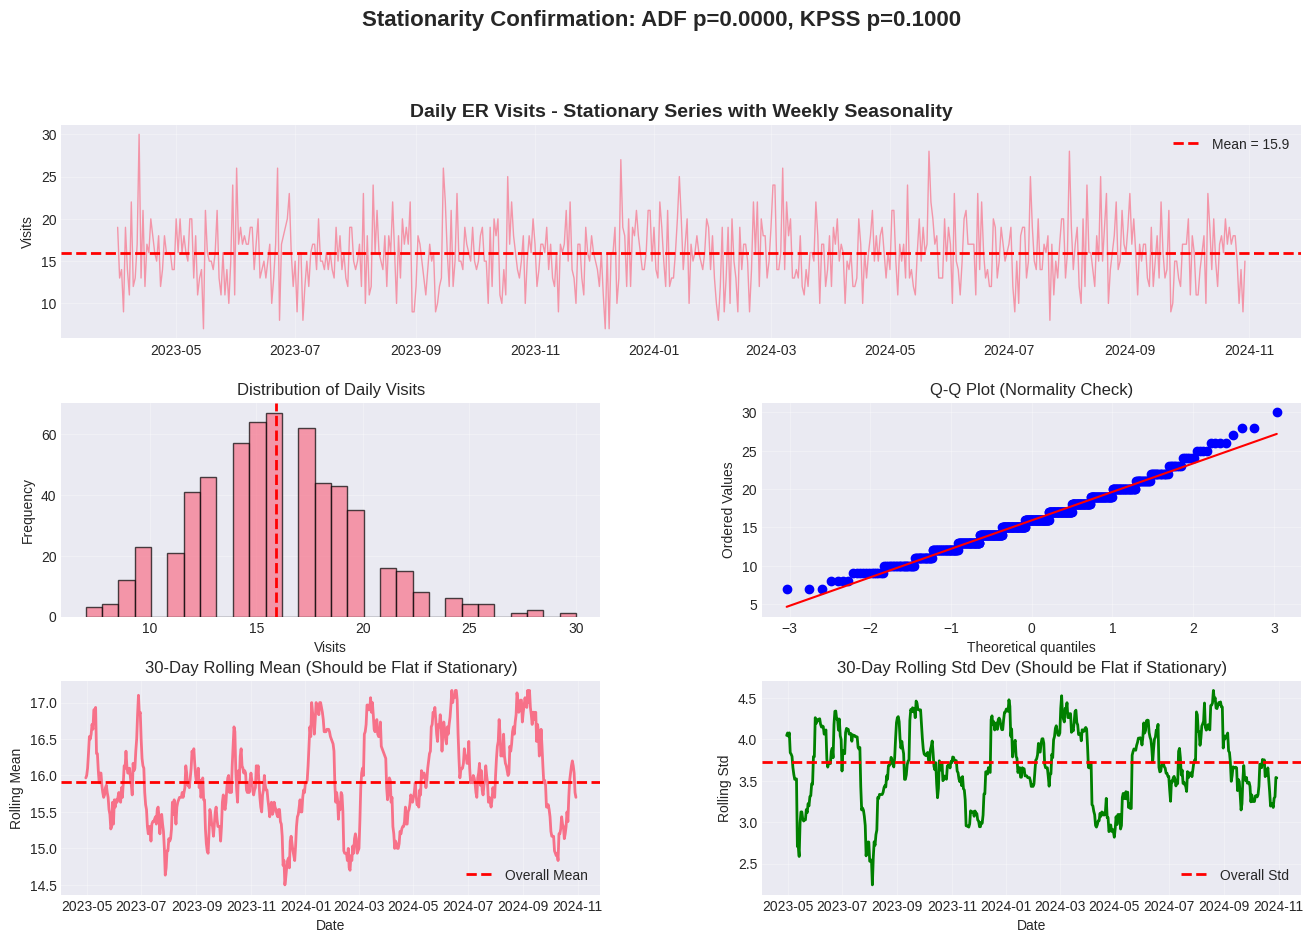

In [45]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Time series plot
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(ts.index, ts.values, linewidth=1, alpha=0.7)
ax1.set_title('Daily ER Visits - Stationary Series with Weekly Seasonality', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Visits')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=ts.mean(), color='red', linestyle='--', 
            label=f'Mean = {ts.mean():.1f}', linewidth=2)
ax1.legend()

# 2. Distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(ts.values, bins=30, edgecolor='black', alpha=0.7)
ax2.axvline(ts.mean(), color='red', linestyle='--', linewidth=2)
ax2.set_title('Distribution of Daily Visits')
ax2.set_xlabel('Visits')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

# 3. Q-Q plot (normality check)
ax3 = fig.add_subplot(gs[1, 1])
from scipy import stats
stats.probplot(ts.values, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)')
ax3.grid(True, alpha=0.3)

# 4. Rolling mean (30-day)
ax4 = fig.add_subplot(gs[2, 0])
rolling_30 = ts.rolling(window=30).mean()
ax4.plot(ts.index, rolling_30.values, linewidth=2)
ax4.axhline(y=ts.mean(), color='red', linestyle='--', linewidth=2, 
            label='Overall Mean')
ax4.set_title('30-Day Rolling Mean (Should be Flat if Stationary)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Rolling Mean')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Rolling std (30-day)
ax5 = fig.add_subplot(gs[2, 1])
rolling_std_30 = ts.rolling(window=30).std()
ax5.plot(ts.index, rolling_std_30.values, linewidth=2, color='green')
ax5.axhline(y=ts.std(), color='red', linestyle='--', linewidth=2, 
            label='Overall Std')
ax5.set_title('30-Day Rolling Std Dev (Should be Flat if Stationary)')
ax5.set_xlabel('Date')
ax5.set_ylabel('Rolling Std')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.suptitle(f'Stationarity Confirmation: ADF p={p_value_original:.4f}, KPSS p={p_value_kpss:.4f}',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [46]:
# 1. Check the index type and continuity
print("="*70)
print("TIME INDEX VERIFICATION")
print("="*70)
print(f"Index type: {type(ts.index)}")
print(f"Index dtype: {ts.index.dtype}")
print(f"\nFirst 10 dates:")
print(ts.index[:10])
print(f"\nLast 10 dates:")
print(ts.index[-10:])

# 2. Check for gaps in the date sequence
print("\n" + "="*70)
print("CHECKING FOR MISSING DATES")
print("="*70)

date_diffs = ts.index.to_series().diff()
print(f"\nExpected frequency: 1 day")
print(f"Date differences (should all be 1 day):")
print(date_diffs.value_counts().sort_index())

# Find any gaps
gaps = date_diffs[date_diffs > pd.Timedelta(days=1)]
if len(gaps) > 0:
    print(f"\n⚠️  WARNING: Found {len(gaps)} gaps in the time series!")
    print("\nGap locations:")
    print(gaps)
else:
    print("\n✓ No gaps found - continuous daily series")

# 3. Check for duplicate dates
print("\n" + "="*70)
print("CHECKING FOR DUPLICATE DATES")
print("="*70)
duplicates = ts.index.duplicated()
if duplicates.any():
    print(f"⚠️  WARNING: Found {duplicates.sum()} duplicate dates!")
    print("\nDuplicate dates:")
    print(ts.index[duplicates])
else:
    print("✓ No duplicate dates found")

# 4. Verify data values
print("\n" + "="*70)
print("DATA VALUES CHECK")
print("="*70)
print(f"Min value: {ts.min()}")
print(f"Max value: {ts.max()}")
print(f"Mean value: {ts.mean():.2f}")
print(f"Std dev: {ts.std():.2f}")
print(f"Number of zeros: {(ts == 0).sum()}")
print(f"Number of NaN: {ts.isna().sum()}")

# 5. Look at raw data structure
print("\n" + "="*70)
print("SAMPLE OF ACTUAL DATA")
print("="*70)
print("\nFirst 14 days (2 weeks):")
print(ts.head(14))

TIME INDEX VERIFICATION
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index dtype: datetime64[ns]

First 10 dates:
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10'],
              dtype='datetime64[ns]', name='date', freq=None)

Last 10 dates:
DatetimeIndex(['2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-26', '2024-10-27', '2024-10-28',
               '2024-10-29', '2024-10-30'],
              dtype='datetime64[ns]', name='date', freq=None)

CHECKING FOR MISSING DATES

Expected frequency: 1 day
Date differences (should all be 1 day):
date
1 days    578
Name: count, dtype: int64

✓ No gaps found - continuous daily series

CHECKING FOR DUPLICATE DATES
✓ No duplicate dates found

DATA VALUES CHECK
Min value: 7
Max value: 30
Mean value: 15.92
Std dev: 3.73
Number of zeros: 0
Number of NaN: 0

## Project 1 Status: COMPLETE ✓

**Date Completed:** 11/8/25

### Key Findings:
- **Dataset:** Hospital ER visits (April 2023 - October 2024, 579 days)
- **Daily visits:** Mean = 15.9, Range = 7-30
- **ADF Test:** p = 0.0000 (strongly stationary)
- **KPSS Test:** p = 0.1000 (confirms stationary)
- **Trend:** No significant trend (p = 0.506)
- **Data Quality:** Perfect - no gaps, no duplicates, continuous daily series

### Conclusions:
- Series is STATIONARY with weekly seasonality
- No transformation needed
- Ready for SARIMA modeling (period=7)
- High day-to-day variability (CV = 23%) is normal for ER data

### Next Steps:
- ACF/PACF analysis for seasonal patterns
- SARIMA model building
- Forecasting

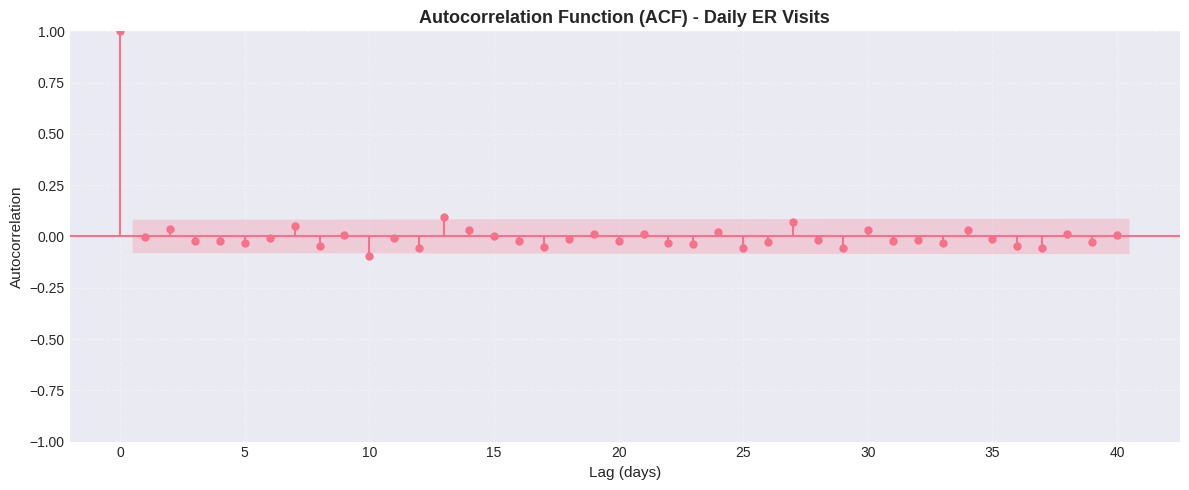

ACF Values (first 10 lags):
Lag 1: -0.0034
Lag 2: 0.0360
Lag 3: -0.0230
Lag 4: -0.0207
Lag 5: -0.0328
Lag 6: -0.0066
Lag 7: 0.0495
Lag 8: -0.0473
Lag 9: 0.0066
Lag 10: -0.0935


In [48]:
# Import statsmodels for ACF/PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Compute ACF values
acf_values = acf(daily_visits['visits'], nlags=40, alpha=0.05)
acf_vals = acf_values[0]
conf_int = acf_values[1]

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(daily_visits['visits'], lags=40, ax=ax, alpha=0.05)
ax.set_xlabel('Lag (days)', fontsize=11)
ax.set_ylabel('Autocorrelation', fontsize=11)
ax.set_title('Autocorrelation Function (ACF) - Daily ER Visits', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print first 10 ACF values
print("ACF Values (first 10 lags):")
for lag in range(1, 11):
    print(f"Lag {lag}: {acf_vals[lag]:.4f}")

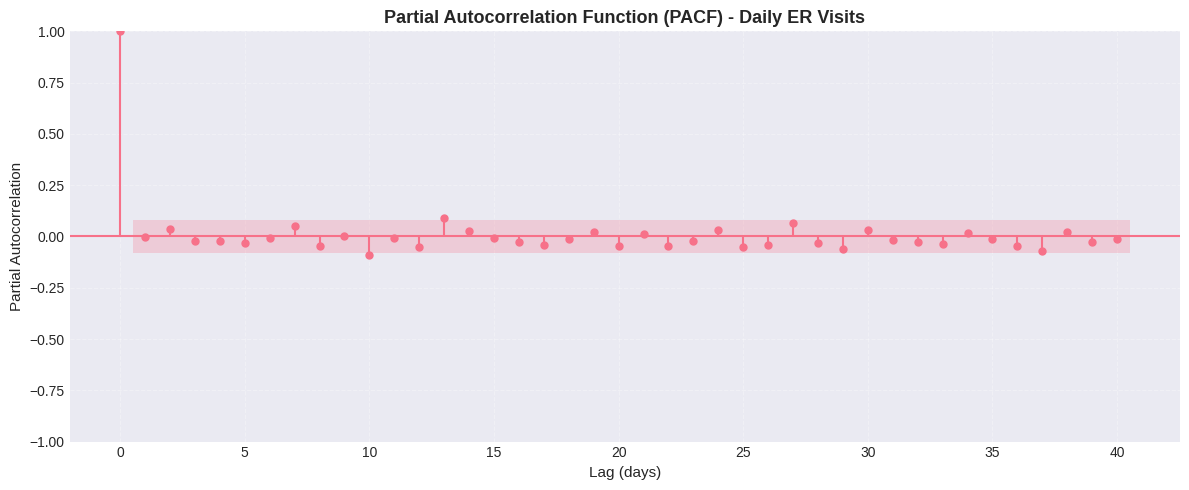


PACF Values (first 10 lags):
Lag 1: -0.0034
Lag 2: 0.0361
Lag 3: -0.0230
Lag 4: -0.0223
Lag 5: -0.0316
Lag 6: -0.0059
Lag 7: 0.0516
Lag 8: -0.0493
Lag 9: 0.0010
Lag 10: -0.0913


In [49]:
# Compute PACF values
pacf_values = pacf(daily_visits['visits'], nlags=40, alpha=0.05)
pacf_vals = pacf_values[0]
pacf_conf_int = pacf_values[1]

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(daily_visits['visits'], lags=40, ax=ax, alpha=0.05)
ax.set_xlabel('Lag (days)', fontsize=11)
ax.set_ylabel('Partial Autocorrelation', fontsize=11)
ax.set_title('Partial Autocorrelation Function (PACF) - Daily ER Visits', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print first 10 PACF values
print("\nPACF Values (first 10 lags):")
for lag in range(1, 11):
    print(f"Lag {lag}: {pacf_vals[lag]:.4f}")



## **Detailed Explanation:**

### **What This Code Does:**
This cell calculates and visualizes the Partial Autocorrelation Function (PACF). While ACF shows **total** correlation including indirect effects, PACF shows **direct** correlation after removing the influence of intermediate lags.

### **Line-by-Line Breakdown:**

1. **`pacf()` function**:
   - Similar to ACF, but computes partial correlations
   - `nlags=40`: Examines up to 40 days back
   - `alpha=0.05`: 95% confidence level
   - Returns PACF values and confidence intervals

2. **Plotting**: Creates a stem plot similar to ACF where:
   - Bars represent the direct correlation at each lag
   - Blue confidence band shows statistical significance
   - Only values outside the band are meaningful

3. **Numerical output**: Prints PACF values for interpretation

---

## **Key Statistical Concepts:**

### **What is Partial Autocorrelation?**

**PACF measures the correlation between Y_t and Y_{t-k} AFTER removing the linear influence of all intermediate lags (Y_{t-1}, Y_{t-2}, ..., Y_{t-k+1}).**

### **The Difference Between ACF and PACF:**

**Example to illustrate:**

Imagine ER visits follow this pattern:
- Monday influences Tuesday (direct effect)
- Tuesday influences Wednesday (direct effect)
- Monday seems to influence Wednesday, but **only through Tuesday** (indirect effect)

**ACF** at lag 2 (Monday → Wednesday):
- Shows the total correlation = 0.65
- Includes both direct AND indirect effects
- "How much does Monday predict Wednesday overall?"

**PACF** at lag 2 (Monday → Wednesday):
- Shows only the direct correlation = 0.05 (very small!)
- Removes the indirect effect through Tuesday
- "How much does Monday predict Wednesday AFTER accounting for Tuesday?"

### **Mathematical Intuition:**

Think of PACF as asking: **"What unique information does lag k provide that wasn't already captured by shorter lags?"**
```
ACF(2) = Direct effect + Indirect effect (through lag 1)
PACF(2) = Direct effect only
```

---

## **Why PACF Matters:**

### **1. Identifying Autoregressive (AR) Order**

PACF is crucial for determining how many past values we need in a model:

- **Sharp cutoff at lag p**: Suggests AR(p) model
  - Example: PACF significant at lags 1-3, then cuts off → AR(3)
  
- **Gradual decay**: Suggests moving average component

### **2. Distinguishing Process Types**

| Pattern | ACF | PACF | Process Type |
|---------|-----|------|--------------|
| Sharp cutoff at lag q | Decay gradually | MA(q) |
| Gradual decay | Sharp cutoff at lag p | AR(p) |
| Gradual decay | Gradual decay | ARMA |
| Spikes at seasonal lags | Spikes at seasonal lags | Seasonal pattern |

### **3. Understanding Direct Relationships**

For your ER data, PACF helps answer:
- "Does last Monday directly affect this Monday, or only through the weekdays in between?"
- "Do visits from 7 days ago have a direct influence, or is it just because they correlate with more recent days?"

---

## **Real-World Example:**

### **Temperature Data:**

**ACF Pattern:**
```
Lag 1: 0.95 (very high)
Lag 2: 0.88 (high)
Lag 3: 0.79 (still high)
Lag 4: 0.68 (moderate)
```
Temperature shows strong correlation many days back.

**PACF Pattern:**
```
Lag 1: 0.95 (very high) ← Direct effect
Lag 2: 0.05 (very low)  ← No additional direct effect
Lag 3: -0.02 (negligible)
Lag 4: 0.01 (negligible)
```

**Interpretation:**
- Only yesterday (lag 1) has a **direct** effect
- Lag 2, 3, 4 correlations in ACF are entirely explained by lag 1
- This is an AR(1) process: Today = c + φ × Yesterday + ε

### **Weekly Pattern Example:**

**PACF for ER visits might show:**

- Lag 1: 0.35  ← Yesterday has some direct effect
- Lag 7: 0.42  ← Last week (same day) has direct effect
- Lag 14: 0.10 ← 2 weeks ago (small direct effect)

**Interpretation:**

- Yesterday matters (short-term dependency)
- Last week's same day matters (weekly seasonality)
- This suggests both recent history AND weekly patterns drive visits


What to Look For in Your PACF Plot:

- Lag 1: Is there short-term persistence? (yesterday → today)
- Lag 7: Weekly pattern? (Does last Monday directly affect this Monday?)
- Cutoff point: Where does PACF drop to insignificance?

- Sharp cutoff at lag 2 → AR(2) model
- Significance through lag 5 → AR(5) model


Seasonal lags: Spikes at 7, 14, 21, 28 days → weekly cycle